<a href="https://colab.research.google.com/github/sarvan0506/AI/blob/Dev/6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use of Functional API and Different types of Convolutions

## Making use of functional API from keras and implement the below mentioned Convolution in the Network

### 1. Normal Convolution
### 2. Spatially Separable Convolution
### 3. Depthwise Separable Convolution
### 4. Grouped Convolution
### 5. Grouped Convolution with Dilation

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, Input, concatenate, BatchNormalization, Dropout, SeparableConv2D, Flatten
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator

# import all necessary libraries and dependencies

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

# load cifar 10 dataset

170500096/170498071 [==============================] - 6s 0us/step


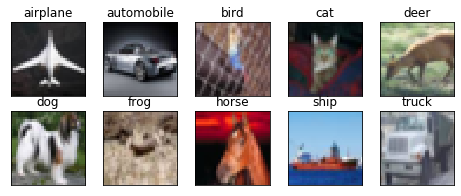

In [0]:
# Print some random images from the dataset

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### A utility function to plot model history

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

### Function to calculate accuracy of a model

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Building the network

In [0]:
input_img = Input(shape=(32, 32, 3))

# Normal Convolution

L1 = Convolution2D(48, 3, 3)(input_img) # output_channel_size - 30
L1 = BatchNormalization()(L1)
L1 = Activation('relu')(L1)
L1 = Dropout(0.1)(L1)

# Spatially Separable Convolution

L21 = Convolution2D(96, 3, 1)(L1) 
L21 = BatchNormalization()(L21)
L21 = Activation('relu')(L21)
L21 = Dropout(0.1)(L21)

L2 = Convolution2D(96, 1, 3)(L21) # output_channel_size - 28
L2 = BatchNormalization()(L2)
L2 = Activation('relu')(L2)
L2 = Dropout(0.1)(L2)

# Maxpooling

M1 = MaxPooling2D(pool_size=(2, 2))(L2) # output_channel_size - 14

# Bottleneck Layer

B1 = Convolution2D(15, 1, 1)(M1)
B1 = BatchNormalization()(B1)
B1 = Activation('relu')(B1)
B1 = Dropout(0.1)(B1)

# Depthwise Separable Convolution

L3 = SeparableConv2D(48, kernel_size=(3, 3))(B1) # output_channel_size - 12
L3 = BatchNormalization()(L3)
L3 = Activation('relu')(L3)
L3 = Dropout(0.1)(L3)

# Grouped Convolution I

L41 = Convolution2D(96, 3, 3, border_mode='same')(L3) # output_channel_size - 12
L41 = BatchNormalization()(L41)
L41 = Activation('relu')(L41)
L41 = Dropout(0.1)(L41)

L42 = Convolution2D(96, 5, 5, border_mode='same')(L3) # output_channel_size - 12
L42 = BatchNormalization()(L42)
L42 = Activation('relu')(L42)
L42 = Dropout(0.1)(L42)

L4 = concatenate([L41, L42], axis=-1)

# Maxpooling

M2 = MaxPooling2D(pool_size=(2, 2))(L4) # output_channel_size - 6

# Bottleneck Layer

B2 = Convolution2D(15, 1, 1)(M2)
B2 = BatchNormalization()(B2)
B2 = Activation('relu')(B2)
B2 = Dropout(0.1)(B2)

# Grouped Convolution II

L51 = Convolution2D(192, 3, 3, dilation_rate=1, border_mode='same')(B2) # output_channel_size - 6
L51 = BatchNormalization()(L51)
L51 = Activation('relu')(L51)
L51 = Dropout(0.1)(L51)


L52 = Convolution2D(192, 3, 3, dilation_rate=2, border_mode='same')(B2) # output_channel_size - 6
L52 = BatchNormalization()(L52)
L52 = Activation('relu')(L52)
L52 = Dropout(0.1)(L52)

L5 = concatenate([L51, L52], axis=-1)


L6 = Convolution2D(6, 1)(L5)
L6 = BatchNormalization()(L5)
L6 = Activation('relu')(L5)

L7 = Convolution2D(10, 6)(L6)

L8 = Flatten()(L7)

out = Activation('softmax')(L8)


model = Model(input_img, out)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`
  """







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 1))`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (1, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(15, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (5, 5), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(15, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarni



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 30, 48)   1344        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 30, 30, 48)   192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 30, 30, 48)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':




Epoch 1/50
390/390 [==============================] - 31s 79ms/step - loss: 1.7313 - acc: 0.4290 - val_loss: 1.5242 - val_acc: 0.4713
Epoch 2/50
390/390 [==============================] - 23s 60ms/step - loss: 1.1930 - acc: 0.5802 - val_loss: 1.2569 - val_acc: 0.5449
Epoch 3/50
390/390 [==============================] - 24s 62ms/step - loss: 0.9863 - acc: 0.6506 - val_loss: 1.1888 - val_acc: 0.5920
Epoch 4/50
390/390 [==============================] - 24s 61ms/step - loss: 0.8889 - acc: 0.6859 - val_loss: 0.8964 - val_acc: 0.6866
Epoch 5/50
390/390 [==============================] - 24s 61ms/step - loss: 0.7906 - acc: 0.7222 - val_loss: 0.9581 - val_acc: 0.6773
Epoch 6/50
390/390 [==============================] - 24s 61ms/step - loss: 0.7289 - acc: 0.7460 - val_loss: 0.9653 - val_acc: 0.6640
Epoch 7/50
390/390 [==============================] - 24s 61ms/step - loss: 0.6821 - acc: 0.7598 - val_loss: 0.7624 - val_acc: 0.7324
Epoch 8/50
390/390 [==============================] - 24s 61

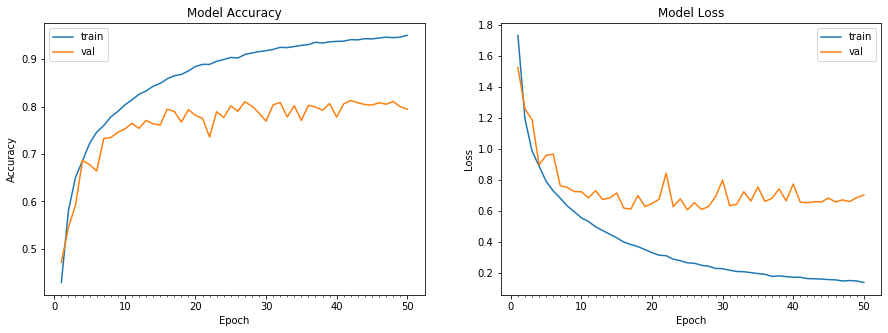

Accuracy on test data is: 79.42


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False) # for Batch normalization


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

#### The Model was able to train reasonably well and by this usage of Different Convolutions and the Functional API in keras is implemented